# Import Library

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [18]:
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 4
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.3
EPOCHS = 10
PATIENCE = 5
BATCH_SIZE = 32
SEED = 42

In [19]:
# set random seed for reproducibility
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
keras.utils.set_random_seed(SEED)

# Load Dataset

In [20]:
# generate data paths with labels
train_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)
train_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [21]:
# generate data paths with labels
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
temp_df = pd.concat([Fseries, Lseries], axis= 1)

In [22]:
valid_df, test_df = train_test_split(temp_df, train_size= 0.5, shuffle= True, stratify=temp_df['labels'], random_state=SEED)

In [23]:
tr_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

ts_gen = ImageDataGenerator(rescale=1./255)

train_ds = tr_gen.flow_from_dataframe(
    train_df,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= IMG_SIZE,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= True,
    batch_size= BATCH_SIZE)

val_ds = ts_gen.flow_from_dataframe(
    valid_df,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= IMG_SIZE,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= False,
    batch_size= BATCH_SIZE)

test_ds = ts_gen.flow_from_dataframe(
    test_df,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= IMG_SIZE,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= False,
    batch_size= BATCH_SIZE)

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# Create Model, Plot, and Evaluation Modules

In [24]:
def create_model(base, fine_tune, dropout_rate, learning_rate):

    if base == "VGG16":
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    elif base == "DenseNet121":
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    elif base == "ResNet50":
        base_model= ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

    total_layers = len(base_model.layers)
    # how many layers to unfreeze
    n_unfreeze = int(total_layers * (30 / 100.0)) # unfreeze 30% of the base's layers

    if fine_tune==False:
        for layer in base_model.layers:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = False
        for layer in base_model.layers[-n_unfreeze:]:
            layer.trainable = True

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [25]:
# Evaluation Functions (plot history & evaluation metrics)
def evaluate_model(model, test_ds, num_classes, class_names=class_names):
    y_pred_probs = model.predict(test_ds, verbose=1)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = test_ds.classes

    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names if class_names else [f'Class {i}' for i in range(num_classes)])
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    results = {
        "overall_accuracy": accuracy,
        "weighted_precision": precision,
        "weighted_recall": recall,
        "weighted_f1_score": f1,
        "classification_report": report,
        "confusion_matrix": conf_matrix
    }

    print("\n=== MODEL EVALUATION ===")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print("\nClassification Report:\n", report)
    print('\n')
    # plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.show()

    return results

def plot_training_history(history, title_prefix="Model Performance"):
    hist_df = pd.DataFrame(history.history)
    hist_df['epoch'] = hist_df.index + 1
    epochs = len(hist_df)

    plt.figure(figsize=(12, 5))
    plt.plot(hist_df['epoch'], hist_df['accuracy'], label='Training Accuracy', marker='o', linestyle='-', color='blue')
    plt.plot(hist_df['epoch'], hist_df['val_accuracy'], label='Validation Accuracy', marker='s', linestyle='--', color='darkorange')

    plt.title(f'{title_prefix} - Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1, epochs + 1, max(1, epochs // 10)))
    plt.grid(True, linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(hist_df['epoch'], hist_df['loss'], label='Training Loss', marker='o', linestyle='-', color='blue')
    plt.plot(hist_df['epoch'], hist_df['val_loss'], label='Validation Loss', marker='s', linestyle='--', color='darkorange')

    min_val_loss = hist_df['val_loss'].min()
    best_epoch = hist_df['val_loss'].idxmin() + 1

    plt.axvline(x=best_epoch, color='red', linestyle=':', linewidth=2, label=f'Best Epoch ({best_epoch})')

    plt.title(f'{title_prefix} - Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(np.arange(1, epochs + 1, max(1, epochs // 10)))
    plt.grid(True, linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n--- Best Performance ---")
    print(f"Best Epoch: {best_epoch}")
    print(f"Min Validation Loss: {min_val_loss:.4f}")
    print(f"Best Validation Accuracy at Best Epoch: {hist_df.loc[hist_df.index[best_epoch-1], 'val_accuracy']:.4f}")

# DenseNet121

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 115s 568ms/step - accuracy: 0.2390 - loss: 1.8187 - val_accuracy: 0.5084 - val_loss: 1.1444
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 533ms/step - accuracy: 0.4259 - loss: 1.3081 - val_accuracy: 0.6489 - val_loss: 0.9044
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 96s 535ms/step - accuracy: 0.5354 - loss: 1.0810 - val_accuracy: 0.6992 - val_loss: 0.7862
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 96s 539ms/step - accuracy: 0.6237 - loss: 0.9169 - val_accuracy: 0.7374 - val_loss: 0.7107
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 96s 535ms/step - accuracy: 0.6784 - loss: 0.8084 - val_accuracy: 0.7603 - val_loss: 0.6595
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 99s 550ms/step - accuracy: 0.7110 - loss: 0.7430 - val_accuracy: 0.7573 - val_loss: 0.6394
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 100s 561ms/step - accuracy: 0.7436 - loss: 0.6955 - val_accuracy: 0.7740 - val_loss: 0.6089
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 96s 539ms/step - accuracy: 0.7452 - loss:

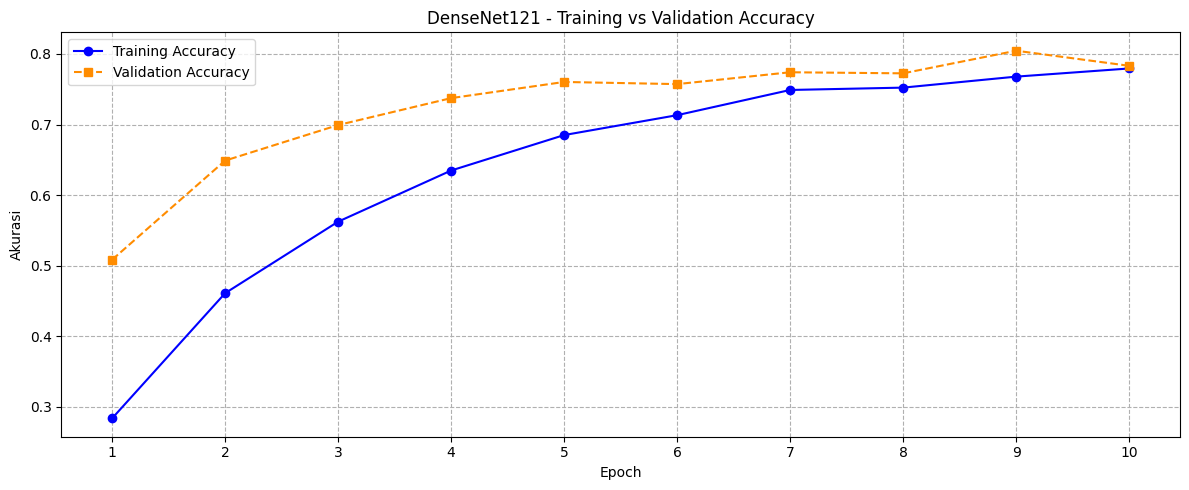

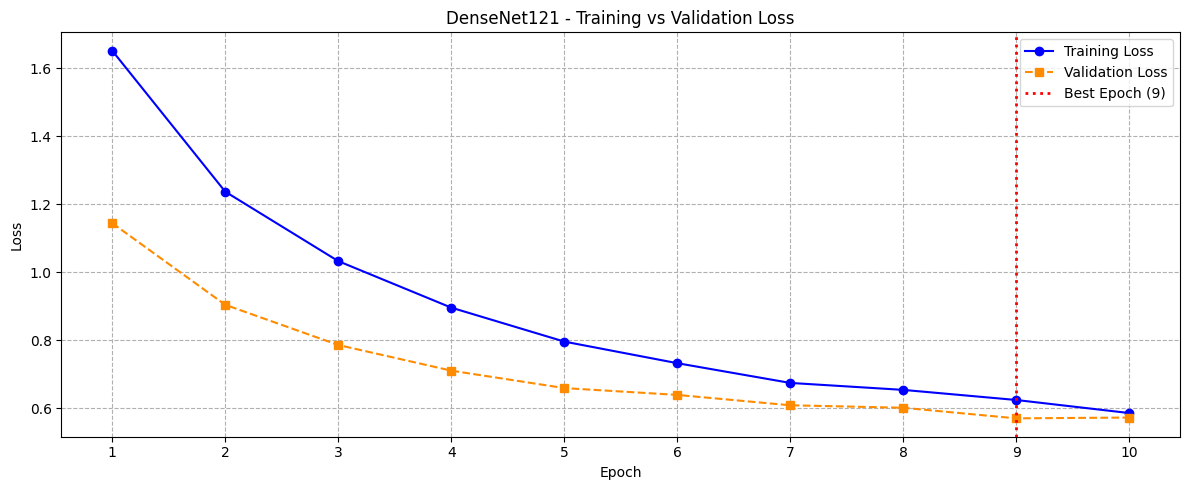


--- Best Performance ---
Best Epoch: 9
Min Validation Loss: 0.5705
Best Validation Accuracy at Best Epoch: 0.8046


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 383ms/step

=== MODEL EVALUATION ===
Overall Accuracy: 0.7607
Weighted Precision: 0.7600
Weighted Recall: 0.7607
Weighted F1-Score: 0.7439

Classification Report:
               precision    recall  f1-score   support

      glioma       0.83      0.74      0.78       150
  meningioma       0.64      0.37      0.47       153
     notumor       0.87      0.92      0.90       203
   pituitary       0.66      0.97      0.78       150

    accuracy                           0.76       656
   macro avg       0.75      0.75      0.73       656
weighted avg       0.76      0.76      0.74       656





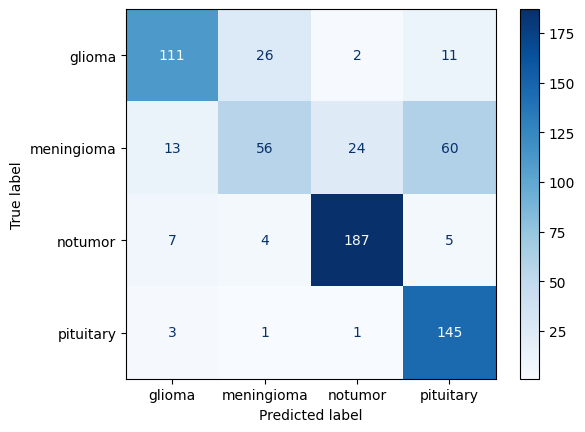

In [26]:
model_densenet121 = create_model(
    "DenseNet121",
    fine_tune=False,
    dropout_rate = DROPOUT_RATE,
    learning_rate = LEARNING_RATE
)

history_densenet121 = model_densenet121.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data = val_ds,
    callbacks=EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
)

plot_training_history(history_densenet121, title_prefix="DenseNet121")
result_densenet121 = evaluate_model(model_densenet121, test_ds, NUM_CLASSES, class_names=class_names)

# Fine Tuned DenseNet121

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 137s 611ms/step - accuracy: 0.7559 - loss: 0.5968 - val_accuracy: 0.9374 - val_loss: 0.1838
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 103s 578ms/step - accuracy: 0.9313 - loss: 0.1822 - val_accuracy: 0.9359 - val_loss: 0.1617
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 104s 581ms/step - accuracy: 0.9577 - loss: 0.1242 - val_accuracy: 0.9603 - val_loss: 0.1075
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 102s 571ms/step - accuracy: 0.9707 - loss: 0.0864 - val_accuracy: 0.9740 - val_loss: 0.0678
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 102s 571ms/step - accuracy: 0.9744 - loss: 0.0763 - val_accuracy: 0.9695 - val_loss: 0.0815
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 103s 575ms/step - accuracy: 0.9843 - loss: 0.0500 - val_accuracy: 0.9756 - val_loss: 0.0595
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 102s 571ms/step - accuracy: 0.9824 - loss: 0.0562 - val_accuracy: 0.9863 - val_loss: 0.0337
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 103s 574ms/step - accuracy: 0.9878 -

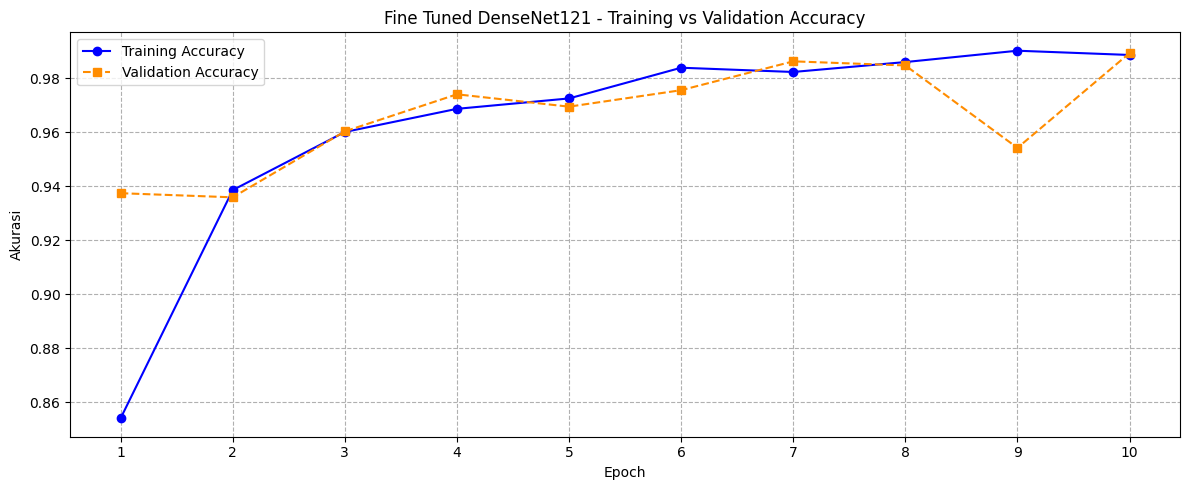

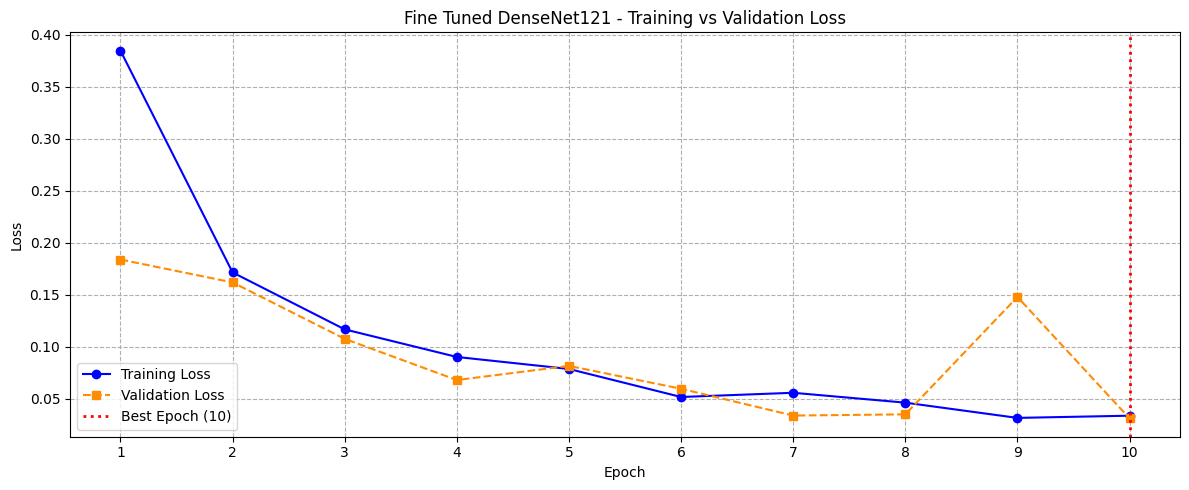


--- Best Performance ---
Best Epoch: 10
Min Validation Loss: 0.0310
Best Validation Accuracy at Best Epoch: 0.9893
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 370ms/step

=== MODEL EVALUATION ===
Overall Accuracy: 0.9909
Weighted Precision: 0.9910
Weighted Recall: 0.9909
Weighted F1-Score: 0.9909

Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      0.97      0.99       150
  meningioma       0.97      0.99      0.98       153
     notumor       1.00      1.00      1.00       203
   pituitary       0.99      1.00      0.99       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656





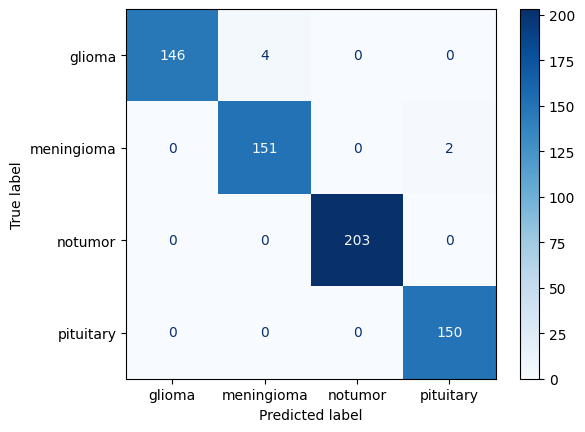

In [27]:
model_finetuned_densenet121 = create_model(
    "DenseNet121",
    fine_tune=True,
    dropout_rate = DROPOUT_RATE,
    learning_rate = LEARNING_RATE
)

history_finetuned_densenet121 = model_finetuned_densenet121.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data = val_ds,
    callbacks=EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
)

plot_training_history(history_finetuned_densenet121, title_prefix="Fine Tuned DenseNet121")
result_finetuned_densenet121 = evaluate_model(model_finetuned_densenet121, test_ds, NUM_CLASSES, class_names=class_names)

# VGG16

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 522ms/step - accuracy: 0.2806 - loss: 1.4303 - val_accuracy: 0.3908 - val_loss: 1.3252
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 94s 523ms/step - accuracy: 0.3162 - loss: 1.3631 - val_accuracy: 0.5038 - val_loss: 1.2814
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 93s 517ms/step - accuracy: 0.3927 - loss: 1.2939 - val_accuracy: 0.5603 - val_loss: 1.2409
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 92s 515ms/step - accuracy: 0.4317 - loss: 1.2646 - val_accuracy: 0.5542 - val_loss: 1.2047
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 93s 522ms/step - accuracy: 0.4847 - loss: 1.2123 - val_accuracy: 0.5985 - val_loss: 1.1709
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 92s 516ms/step - accuracy: 0.5335 - loss: 1.1786 - val_accuracy: 0.5756 - val_loss: 1.1429
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 92s 513ms/step - accuracy: 0.5596 - loss: 1.1477 - val_accuracy: 0.6321 - val_loss: 1.1138
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 94s 523ms/step - accuracy: 0.5769 - loss: 1

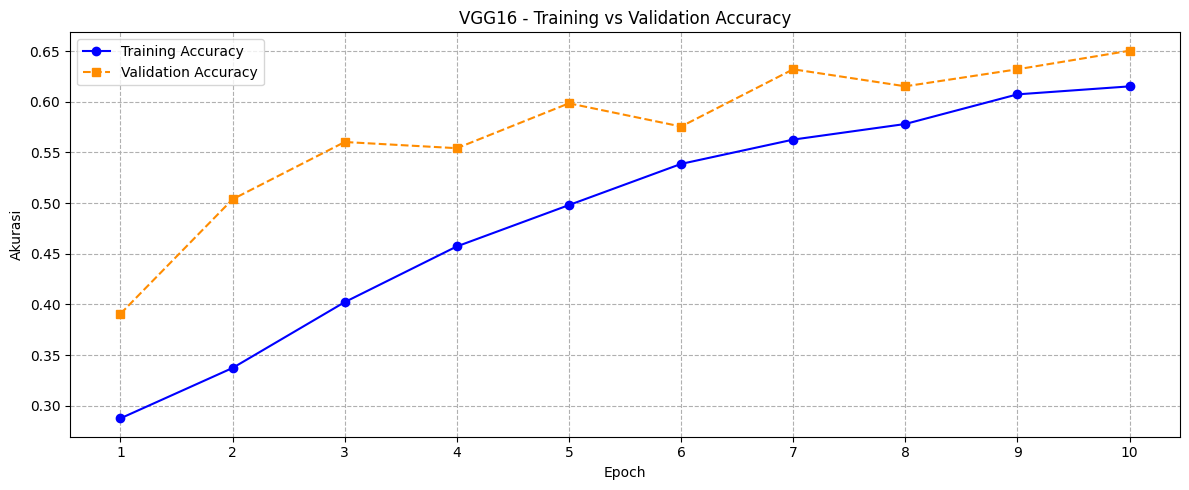

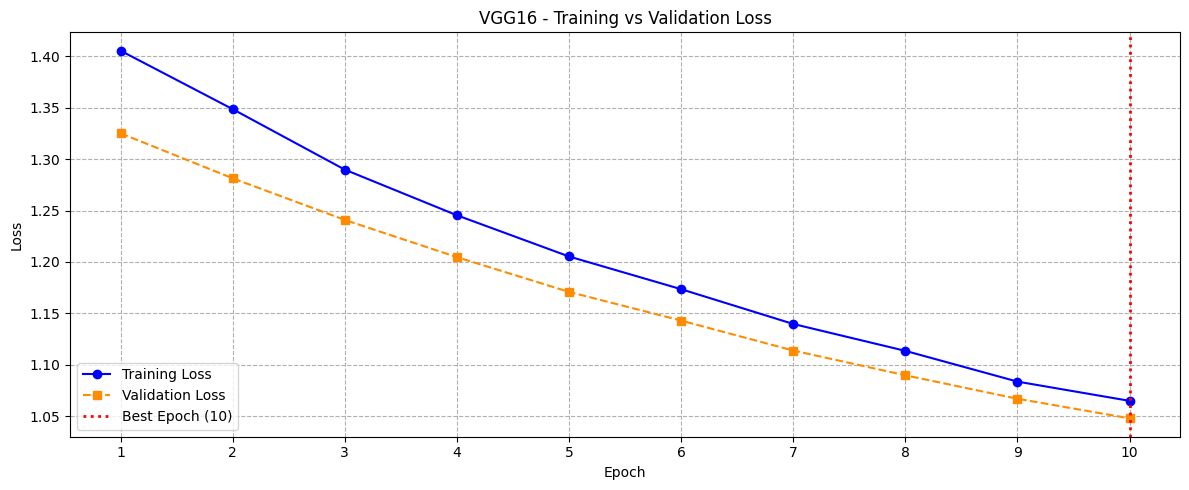


--- Best Performance ---
Best Epoch: 10
Min Validation Loss: 1.0478
Best Validation Accuracy at Best Epoch: 0.6504
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step

=== MODEL EVALUATION ===
Overall Accuracy: 0.6311
Weighted Precision: 0.6284
Weighted Recall: 0.6311
Weighted F1-Score: 0.6123

Classification Report:
               precision    recall  f1-score   support

      glioma       0.75      0.55      0.63       150
  meningioma       0.52      0.31      0.39       153
     notumor       0.64      0.89      0.74       203
   pituitary       0.60      0.69      0.64       150

    accuracy                           0.63       656
   macro avg       0.63      0.61      0.60       656
weighted avg       0.63      0.63      0.61       656





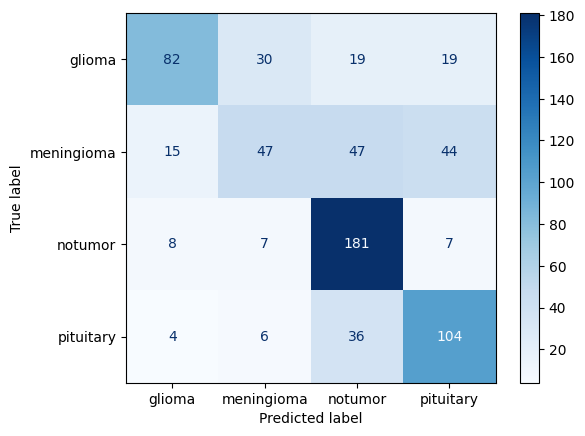

In [28]:
model_vgg16 = create_model(
    "VGG16",
    fine_tune=False,
    dropout_rate = DROPOUT_RATE,
    learning_rate = LEARNING_RATE
)

history_vgg16 = model_vgg16.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data = val_ds,
    callbacks=EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
)

plot_training_history(history_vgg16, title_prefix="VGG16")
result_vgg16 = evaluate_model(model_vgg16, test_ds, NUM_CLASSES, class_names=class_names)

# Fine Tuned VGG16

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 101s 553ms/step - accuracy: 0.6202 - loss: 0.9003 - val_accuracy: 0.8382 - val_loss: 0.4919
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 98s 550ms/step - accuracy: 0.8748 - loss: 0.3300 - val_accuracy: 0.9023 - val_loss: 0.2454
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 98s 545ms/step - accuracy: 0.9071 - loss: 0.2531 - val_accuracy: 0.8901 - val_loss: 0.2856
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 98s 546ms/step - accuracy: 0.9256 - loss: 0.2040 - val_accuracy: 0.9328 - val_loss: 0.1701
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 100s 556ms/step - accuracy: 0.9432 - loss: 0.1581 - val_accuracy: 0.9450 - val_loss: 0.1383
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 98s 544ms/step - accuracy: 0.9596 - loss: 0.1131 - val_accuracy: 0.9603 - val_loss: 0.1056
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 97s 544ms/step - accuracy: 0.9651 - loss: 0.1099 - val_accuracy: 0.9664 - val_loss: 0.0951
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 99s 556ms/step - accuracy: 0.9610 - loss:

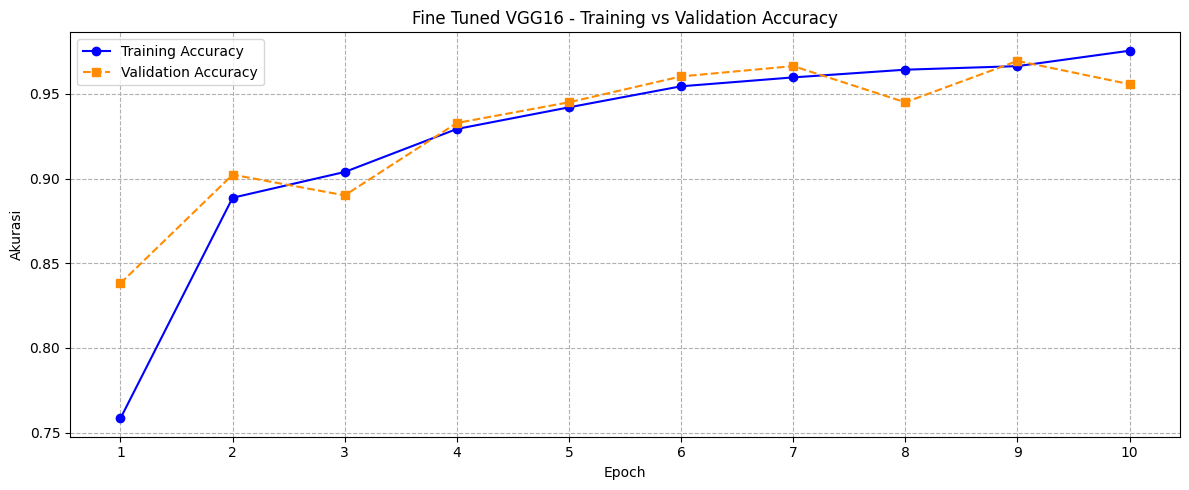

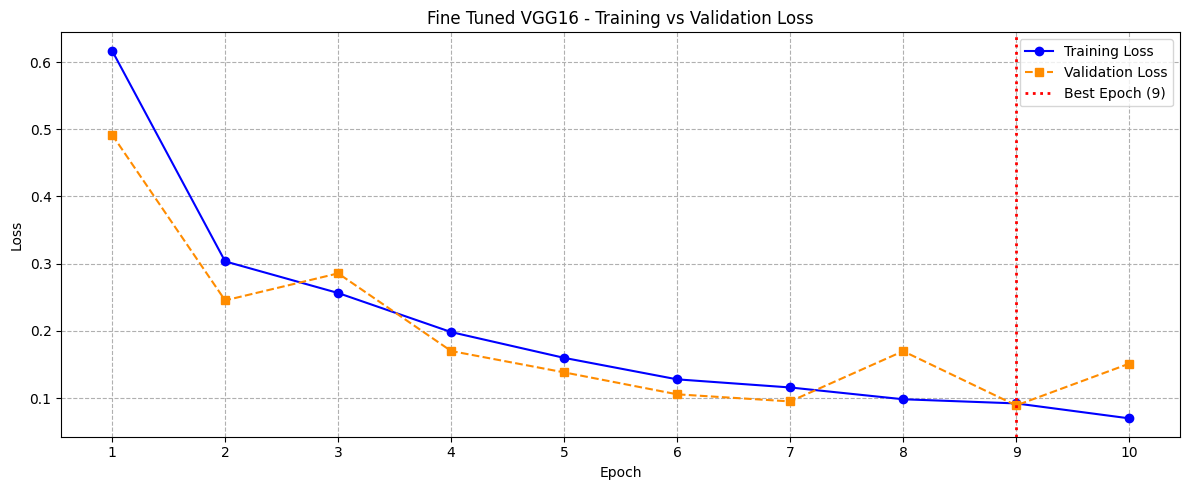


--- Best Performance ---
Best Epoch: 9
Min Validation Loss: 0.0891
Best Validation Accuracy at Best Epoch: 0.9695
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step

=== MODEL EVALUATION ===
Overall Accuracy: 0.9695
Weighted Precision: 0.9711
Weighted Recall: 0.9695
Weighted F1-Score: 0.9695

Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.90      0.94       150
  meningioma       0.91      0.98      0.94       153
     notumor       0.98      1.00      0.99       203
   pituitary       1.00      0.99      0.99       150

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.97      0.97      0.97       656





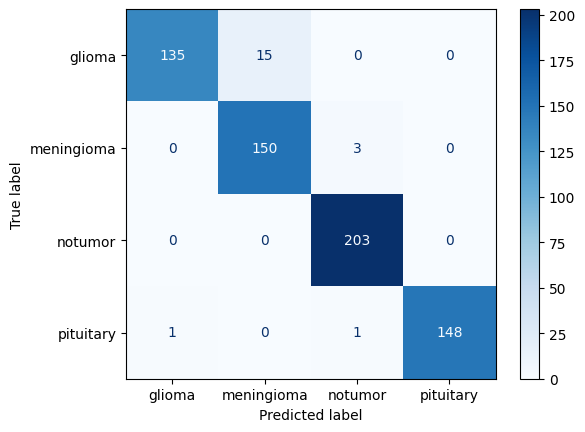

In [29]:
model_finetuned_vgg16 = create_model(
    "VGG16",
    fine_tune=True,
    dropout_rate = DRingOPOUT_RATE,
    learning_rate = LEARNING_RATE
)

history_finetunedvgg16 = model_finetuned_vgg16.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data = val_ds,
    callbacks=EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
)

plot_training_history(history_finetunedvgg16, title_prefix="Fine Tuned VGG16")
result_finetuned_vgg16 = evaluate_model(model_finetuned_vgg16, test_ds, NUM_CLASSES, class_names=class_names)

# ResNet50

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 103s 544ms/step - accuracy: 0.2497 - loss: 1.6357 - val_accuracy: 0.4122 - val_loss: 1.3230
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 96s 537ms/step - accuracy: 0.3020 - loss: 1.4265 - val_accuracy: 0.4122 - val_loss: 1.2833
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 94s 526ms/step - accuracy: 0.3354 - loss: 1.3828 - val_accuracy: 0.3924 - val_loss: 1.2516
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 94s 523ms/step - accuracy: 0.3706 - loss: 1.3112 - val_accuracy: 0.4458 - val_loss: 1.2300
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 93s 521ms/step - accuracy: 0.3938 - loss: 1.2677 - val_accuracy: 0.4229 - val_loss: 1.2171
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 94s 523ms/step - accuracy: 0.3853 - loss: 1.2620 - val_accuracy: 0.3908 - val_loss: 1.2090
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 94s 525ms/step - accuracy: 0.3966 - loss: 1.2310 - val_accuracy: 0.4198 - val_loss: 1.1978
Epoch 8/10
179/179 ━━━━━━━━━━━━

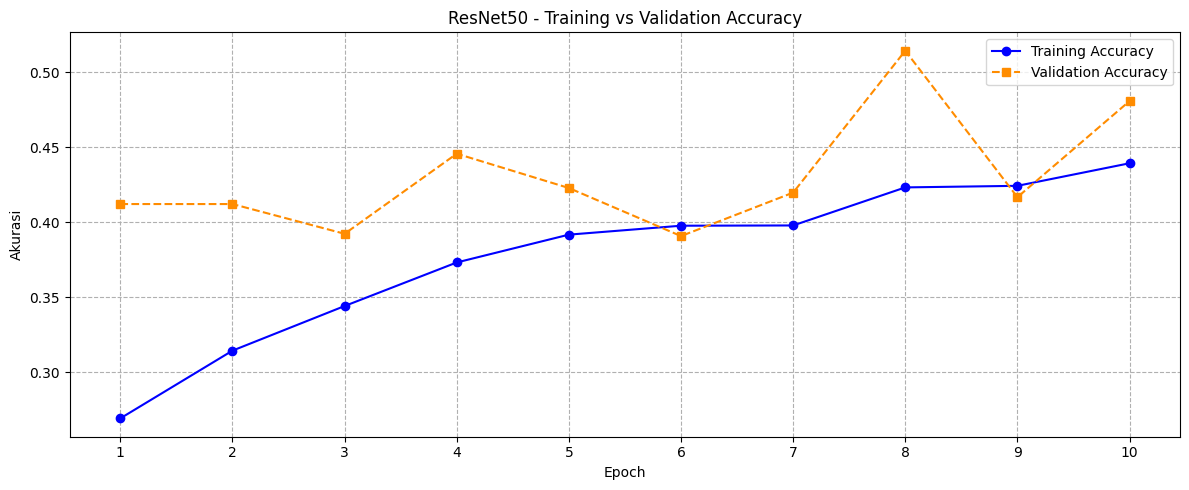

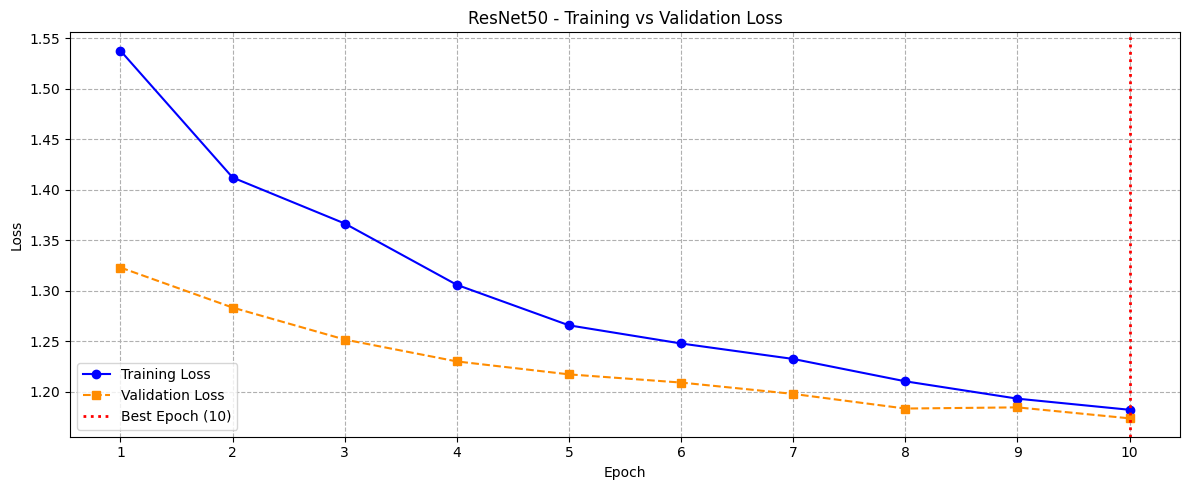


--- Best Performance ---
Best Epoch: 10
Min Validation Loss: 1.1736
Best Validation Accuracy at Best Epoch: 0.4809
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step

=== MODEL EVALUATION ===
Overall Accuracy: 0.4726
Weighted Precision: 0.3848
Weighted Recall: 0.4726
Weighted F1-Score: 0.4026

Classification Report:
               precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       150
  meningioma       0.46      0.26      0.33       153
     notumor       0.62      0.74      0.68       203
   pituitary       0.37      0.80      0.50       150

    accuracy                           0.47       656
   macro avg       0.36      0.45      0.38       656
weighted avg       0.38      0.47      0.40       656





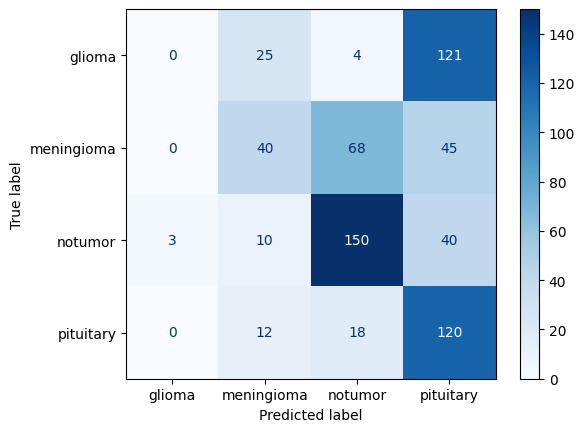

In [30]:
model_resnet50 = create_model(
    "ResNet50",
    fine_tune=False,
    dropout_rate = DROPOUT_RATE,
    learning_rate = LEARNING_RATE
)

history_resnet50 = model_resnet50.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data = val_ds,
    callbacks=EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
)

plot_training_history(history_resnet50, title_prefix="ResNet50")
result_resnet50 = evaluate_model(model_resnet50, test_ds, NUM_CLASSES, class_names=class_names)

# Fine Tuned ResNet50

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 125s 620ms/step - accuracy: 0.4876 - loss: 1.1419 - val_accuracy: 0.3802 - val_loss: 1.6104
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 109s 610ms/step - accuracy: 0.6159 - loss: 0.8939 - val_accuracy: 0.4153 - val_loss: 3.5593
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 112s 624ms/step - accuracy: 0.6322 - loss: 0.8514 - val_accuracy: 0.5267 - val_loss: 1.7106
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 616ms/step - accuracy: 0.6745 - loss: 0.7957 - val_accuracy: 0.6595 - val_loss: 0.8368
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 109s 609ms/step - accuracy: 0.6782 - loss: 0.7580 - val_accuracy: 0.5313 - val_loss: 1.9690
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 614ms/step - accuracy: 0.6914 - loss: 0.7447 - val_accuracy: 0.4962 - val_loss: 1.5078
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 615ms/step - accuracy: 0.6953 - loss: 0.7156 - val_accuracy: 0.6092 - val_loss: 1.1324
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 615ms/step - accuracy: 0.7025 -

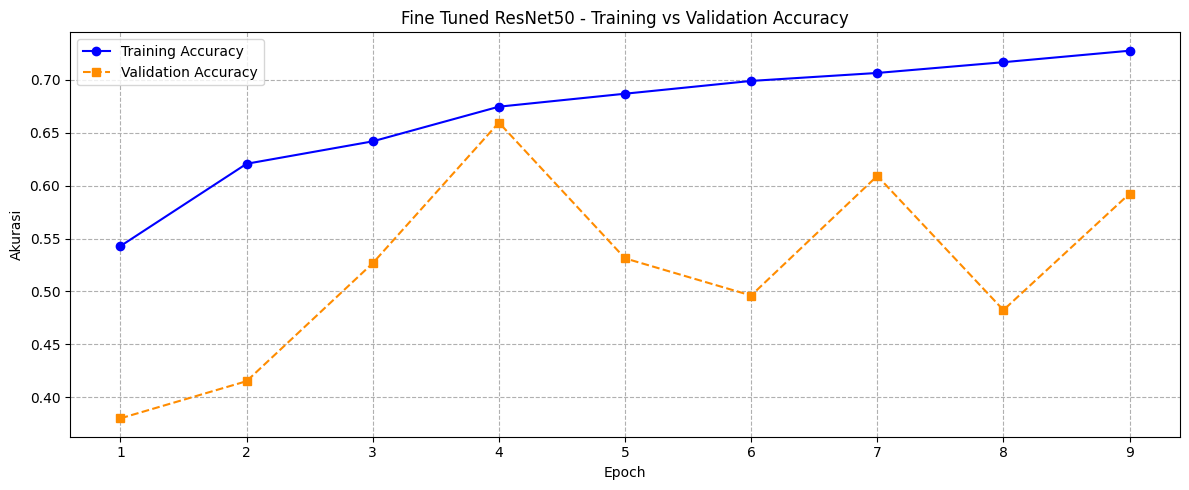

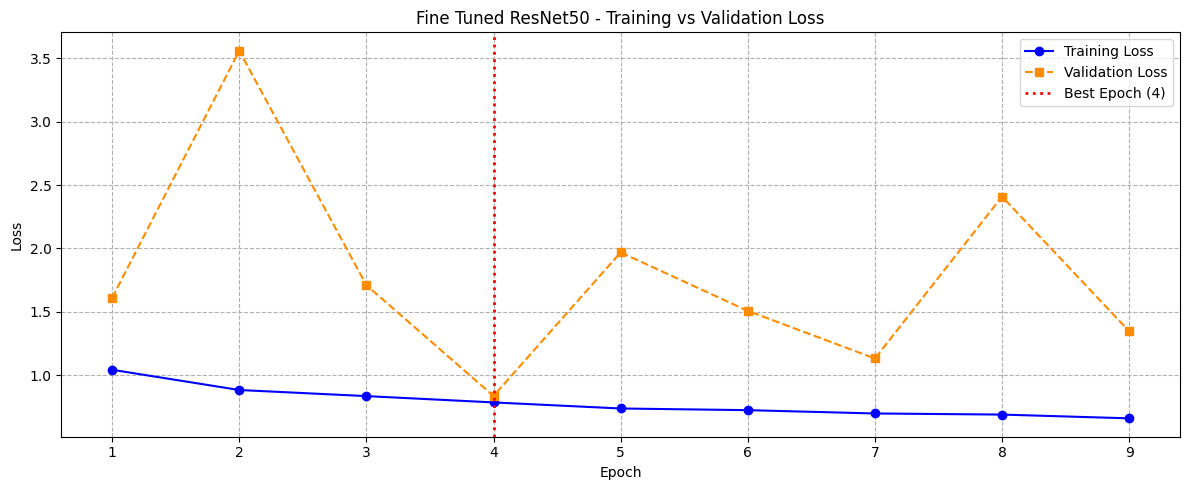


--- Best Performance ---
Best Epoch: 4
Min Validation Loss: 0.8368
Best Validation Accuracy at Best Epoch: 0.6595
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step

=== MODEL EVALUATION ===
Overall Accuracy: 0.6616
Weighted Precision: 0.6534
Weighted Recall: 0.6616
Weighted F1-Score: 0.6426

Classification Report:
               precision    recall  f1-score   support

      glioma       0.66      0.59      0.63       150
  meningioma       0.56      0.35      0.43       153
     notumor       0.67      0.97      0.79       203
   pituitary       0.71      0.63      0.67       150

    accuracy                           0.66       656
   macro avg       0.65      0.64      0.63       656
weighted avg       0.65      0.66      0.64       656





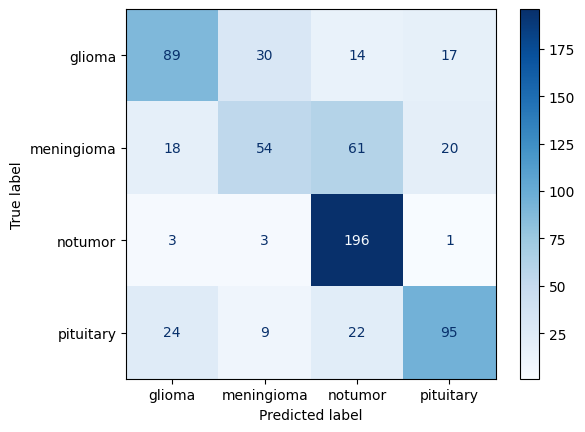

In [31]:
model_finetuned_resnet50 = create_model(
    "ResNet50",
    fine_tune=True,
    dropout_rate = DROPOUT_RATE,
    learning_rate = LEARNING_RATE
)

history_finetuned_resnet50 = model_finetuned_resnet50.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data = val_ds,
    callbacks=EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
)

plot_training_history(history_finetuned_resnet50, title_prefix="Fine Tuned ResNet50")
result_finetuned_resnet50 = evaluate_model(model_finetuned_resnet50, test_ds, NUM_CLASSES, class_names=class_names)